In [1]:
import json
import re
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from tqdm import tqdm

from micromanager_gui._plate_viewer._util import GENOTYPE_MAP, TREATMENT_MAP, ROIData

In [2]:
P1 = 5
P2 = 100

In [ ]:
def _filter_data(path_list: list[Path]) -> list[Path]:
    filtered_paths: list[Path] = []

    # the json file names should be in the form A1_0000.json
    for f in path_list:
        if f.name in {GENOTYPE_MAP, TREATMENT_MAP}:
            continue
        # skip hidden files
        if f.name.startswith("."):
            continue

        name_no_suffix = f.name.removesuffix(f.suffix)  # A1_0000 or A1_0000_p0
        split_name = name_no_suffix.split("_")  # ["A1","0000"]or["A1","0000","p0"]

        if len(split_name) == 2:
            well, fov = split_name
        elif len(split_name) == 3:
            well, fov, pos = split_name
        else:
            continue

        # validate well format, only letters and numbers
        if not re.match(r"^[a-zA-Z0-9]+$", well):
            continue

        # validate fov format, only numbers
        if len(split_name) == 3:
            if not fov.isdigit():
                continue
            if not pos[1:].isdigit():
                continue

        filtered_paths.append(f)

    return filtered_paths


def _load_and_set_data_from_json(path: Path) -> dict[str, dict[str, ROIData]]:
    """Load the analysis data from the given JSON file."""
    _pv_analysis_data = {}
    json_files = _filter_data(list(path.glob("*.json")))
    print(f"Found {len(json_files)} json files.")
    # loop over the files in the directory
    for f in tqdm(json_files, desc="Loading Analysis Data"):
        # get the name of the file without the extensions
        well = f.name.removesuffix(f.suffix)
        # create the dict for the well
        _pv_analysis_data[well] = {}
        # open the data for the well
        with open(f) as file:
            data = cast(dict, json.load(file))
        # if the data is empty, continue
        if not data:
            continue
        # loop over the rois
        for roi in data.keys():
            if not roi.isdigit():
                # this is the case of global data
                # (e.g. cubic or linear global connectivity)
                _pv_analysis_data[roi] = data[roi]
                continue
            # get the data for the roi
            fov_data = cast(dict, data[roi])
            # remove any key that is not in ROIData
            for key in list(fov_data.keys()):
                if key not in ROIData.__annotations__:
                    fov_data.pop(key)
            # convert to a ROIData object and add store it in _analysis_data
            _pv_analysis_data[well][roi] = ROIData(**fov_data)
    return _pv_analysis_data


def _normalize_trace_percentile(
    trace: list[float] | np.ndarray, p1: float, p2: float
) -> np.ndarray:
    """Normalize a trace using p1th-p2th percentile, clipped to [0, 1]."""
    tr = np.array(trace) if isinstance(trace, list) else trace
    denom = p2 - p1
    if denom == 0:
        return np.zeros_like(tr)
    normalized = (tr - p1) / denom
    return np.clip(normalized, 0, 1)


def _plot_normalized_traces(data: dict[str, ROIData]) -> tuple[float, float]:
    """Get the percentiles of the data."""
    fig, ax = plt.subplots()
    p1 = p2 = 0.0
    all_values = []
    for roi_data in data.values():
        if (trace := roi_data.dec_dff) and roi_data.active:
            all_values.extend(trace)
    if all_values:
        percentiles = np.percentile(all_values, [P1, P2])
        p1, p2 = float(percentiles[0]), float(percentiles[1])
    else:
        p1, p2 = 0.0, 1.0
    count = 0
    for roi_key, roi_data in data.items():
        if not roi_data.active:
            continue
        offset = count * 1.1
        trace = _normalize_trace_percentile(roi_data.dec_dff, p1, p2) + offset
        ax.plot(trace, label=f"ROI {roi_key}")
        ax.set_yticks([])
        ax.set_yticklabels([])
        count += 1
    plt.show()

In [4]:
analysis_path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s_analysis"
analysis_data = _load_and_set_data_from_json(Path(analysis_path))

labels_path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s_labels"

Found 80 json files.


Loading Analysis Data: 100%|██████████| 80/80 [00:01<00:00, 59.64it/s]


In [24]:
well = list(analysis_data.keys())[12]
print(f"Well: {well}")

Well: B10_0000_p12


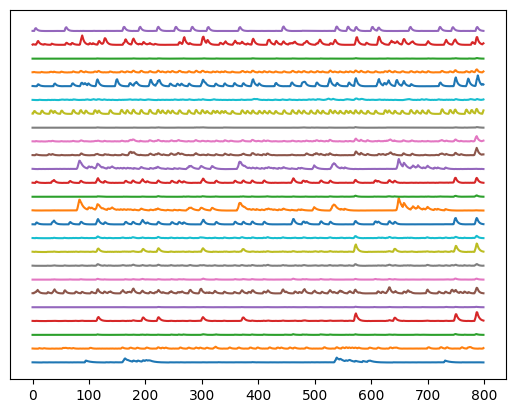

In [25]:
data = analysis_data[well]
_plot_normalized_traces(data)

In [26]:
traces: list[float] = []
rois: list[int] = []
# get the traces for the active rois
for roi, roi_data in analysis_data[well].items():
    roi_data = cast(ROIData, roi_data)
    if roi_data.active:
        rois.append(int(roi))
        traces.append(roi_data.dec_dff)

traces_array = np.array(traces)  # shape (n_rois, n_frames)

print(len(traces_array), len(rois))

25 25


In [27]:
dff_zero_mean = zscore(traces_array, axis=1)

# dff_zero_mean = traces_array - traces_array.mean(axis=1, keepdims=True)

In [28]:
from scipy.signal import correlate

n_rois_active = len(rois)
correlation_matrix_active = np.zeros((n_rois_active, n_rois_active))
for i in range(n_rois_active):
    for j in range(n_rois_active):
        x = dff_zero_mean[i]
        y = dff_zero_mean[j]
        corr = correlate(x, y, mode="full", method="fft")
        corr /= np.linalg.norm(x) * np.linalg.norm(y)  # normalises magnitude
        correlation_matrix_active[i, j] = np.max(corr)

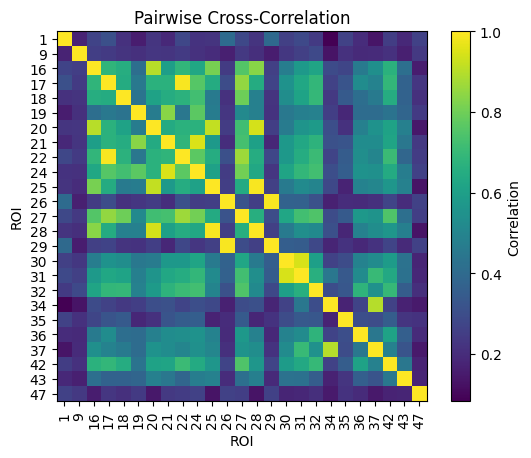

In [29]:
plt.imshow(correlation_matrix_active, cmap="viridis")
plt.colorbar(label="Correlation")
plt.title("Pairwise Cross-Correlation")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.xticks(range(n_rois_active), [f"{i}" for i in rois], rotation=90)
plt.yticks(range(n_rois_active), [f"{i}" for i in rois])
plt.show()

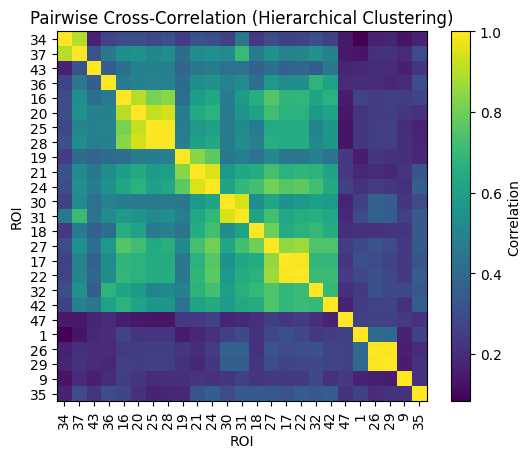

In [30]:
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import squareform

correlation_matrix_active = np.round(correlation_matrix_active, decimals=6)

dist_condensed = squareform(1 - np.abs(correlation_matrix_active))
order = leaves_list(linkage(dist_condensed, method="complete"))

reordered_labels = [f"{rois[i]}" for i in order]

plt.imshow(correlation_matrix_active[order][:, order], cmap="viridis")
plt.colorbar(label="Correlation")
plt.title("Pairwise Cross-Correlation (Hierarchical Clustering)")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.xticks(range(n_rois_active), reordered_labels, rotation=90)
plt.yticks(range(n_rois_active), reordered_labels)
plt.show()

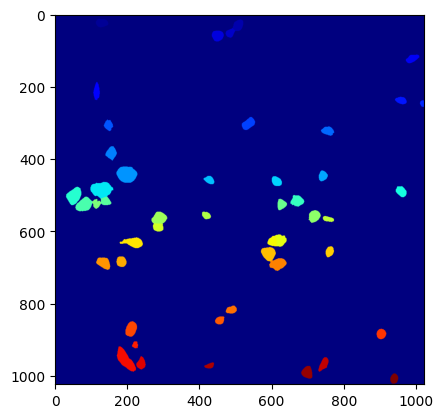

In [31]:
# label image
import tifffile

label_images = Path(labels_path).glob("*.tif")
# look for the label image that matches the well name "well"
label_image = None
for label_image in label_images:
    if label_image.name.startswith(well):
        break
if label_image is None:
    raise ValueError(f"No label image found for well {well}")

labels = tifffile.imread(label_image)

# labels = np.where(labels == 4, 1, 0)  # binarize the labels
plt.imshow(labels, cmap="jet")

In [32]:
import numpy as np
from scipy.stats import pearsonr


def compute_connectivity_matrix(data, lag_max=1, correlation_threshold=0.3):
    """
    Compute connectivity matrix from binarized time series data.

    Parameters
    ----------
    - data: Dictionary containing analysis data for each well
    - lag_max: Maximum lag to consider for cross-correlation
    - correlation_threshold: Threshold above which a connection is considered significant

    Returns
    -------
    - connectivity_matrix: Binary matrix (1 = connected, 0 = not connected)
    - correlation_matrix: Matrix of correlation values
    - lag_matrix: Matrix of optimal lags
    """
    binarized_activity = {}
    for roi, roi_data in data.items():
        if not roi_data.active:
            continue
        trace_len = len(roi_data.dec_dff)
        peaks = roi_data.peaks_dec_dff
        for i in range(trace_len):
            if i in peaks:
                binarized_activity.setdefault(roi, []).append(1)
            else:
                binarized_activity.setdefault(roi, []).append(0)

    binarized_matrix = np.array([binarized_activity[roi] for roi in roi_keys_sorted])

    n_cells, n_timepoints = binarized_matrix.shape

    connectivity_matrix = np.zeros((n_cells, n_cells))
    correlation_matrix = np.zeros((n_cells, n_cells))
    lag_matrix = np.zeros((n_cells, n_cells))

    for i in range(n_cells):
        for j in range(n_cells):
            if i == j:
                connectivity_matrix[i, j] = 1
                correlation_matrix[i, j] = 1
                continue

            max_corr = 0
            best_lag = 0

            for lag in range(-lag_max, lag_max + 1):
                # Extract aligned segments
                if lag >= 0:
                    x = binarized_matrix[i, lag:]
                    y = binarized_matrix[j, : n_timepoints - lag]
                else:
                    x = binarized_matrix[i, : n_timepoints + lag]
                    y = binarized_matrix[j, -lag:]

                # Skip if segments are too short or have no variation
                if len(x) < 3 or len(y) < 3 or np.var(x) == 0 or np.var(y) == 0:
                    continue

                try:
                    corr, _ = pearsonr(x, y)
                    if not np.isnan(corr) and abs(corr) > abs(max_corr):
                        max_corr = corr
                        best_lag = lag
                except Exception:
                    continue

            correlation_matrix[i, j] = max_corr
            lag_matrix[i, j] = best_lag

            # Set connection if correlation exceeds threshold
            if abs(max_corr) >= correlation_threshold:
                connectivity_matrix[i, j] = 1

    return connectivity_matrix, correlation_matrix, lag_matrix


# Convert binarized_activity dict to matrix
roi_keys_sorted = sorted(binarized_activity.keys(), key=int)
binarized_matrix = np.array([binarized_activity[roi] for roi in roi_keys_sorted])

# Compute connectivity
connectivity, correlations, lags = compute_connectivity_matrix(
    analysis_data[well], lag_max=3, correlation_threshold=0.2
)

print(f"Number of connections: {np.sum(connectivity) - len(roi_keys_sorted)}")
print(
    f"Network density: {(np.sum(connectivity) - len(roi_keys_sorted)) / (len(roi_keys_sorted) * (len(roi_keys_sorted) - 1)):.3f}"
)

KeyError: '46'

Found 13/14 ROIs in label image


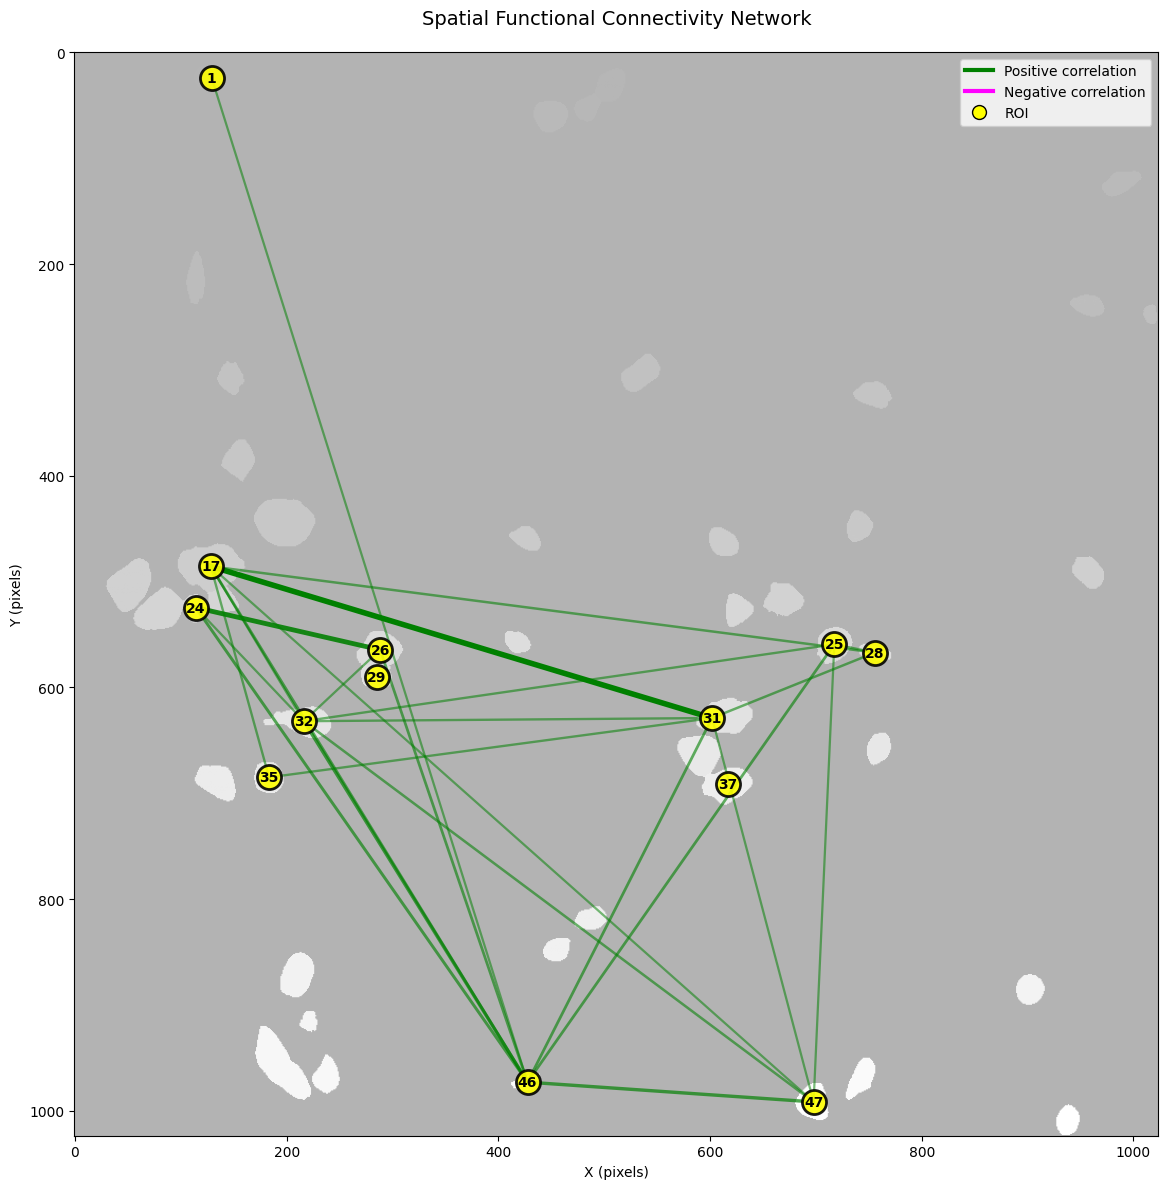


Spatial Network Statistics:
ROI positions range: X=[114.2, 755.7], Y=[24.2, 991.6]
Average distance between connected ROIs: 405.3 pixels
Connection distance range: 39.1 - 994.5 pixels


In [33]:
def get_roi_coordinates(labels, roi_keys):
    """
    Extract centroid coordinates for each ROI from the label image.

    Parameters
    ----------
    - labels: 2D label image where each ROI has a unique pixel value
    - roi_keys: List of ROI identifiers (should match pixel values in labels)

    Returns
    -------
    - coordinates: Dictionary mapping ROI keys to (x, y) coordinates
    """
    coordinates = {}

    for roi_key in roi_keys:
        roi_value = int(roi_key)
        # Find pixels belonging to this ROI
        roi_mask = labels == roi_value

        if np.any(roi_mask):
            # Calculate centroid
            y_coords, x_coords = np.where(roi_mask)
            centroid_x = np.mean(x_coords)
            centroid_y = np.mean(y_coords)
            coordinates[roi_key] = (centroid_x, centroid_y)
        else:
            print(f"Warning: ROI {roi_key} not found in label image")

    return coordinates


def plot_spatial_connectivity_network(
    connectivity_matrix, correlation_matrix, roi_labels, labels_image
):
    """
    Plot network using actual spatial positions from label image.

    Parameters
    ----------
    - connectivity_matrix: Binary connectivity matrix
    - correlation_matrix: Correlation values matrix
    - roi_labels: List of ROI identifiers
    - labels_image: 2D label image with ROI positions
    """
    # Get ROI coordinates from label image
    coordinates = get_roi_coordinates(labels_image, roi_labels)

    # Filter out ROIs that weren't found in the label image
    valid_indices = []
    valid_roi_labels = []
    pos_x = []
    pos_y = []

    for i, roi_key in enumerate(roi_labels):
        if roi_key in coordinates:
            valid_indices.append(i)
            valid_roi_labels.append(roi_key)
            x, y = coordinates[roi_key]
            pos_x.append(x)
            pos_y.append(y)

    pos_x = np.array(pos_x)
    pos_y = np.array(pos_y)
    n_valid = len(valid_roi_labels)

    print(f"Found {n_valid}/{len(roi_labels)} ROIs in label image")

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 12))

    # Show the label image as background (optional) - no need to flip here
    ax.imshow(labels_image, cmap="gray", alpha=0.3, origin="upper")

    # Draw edges first (so they appear behind nodes)
    for i in range(n_valid):
        for j in range(i + 1, n_valid):
            orig_i = valid_indices[i]
            orig_j = valid_indices[j]

            if connectivity_matrix[orig_i, orig_j] == 1:
                # Line thickness and alpha based on correlation strength
                corr_strength = abs(correlation_matrix[orig_i, orig_j])
                linewidth = 1 + corr_strength * 3  # Scale from 1 to 4
                alpha = 0.4 + 0.6 * corr_strength  # Scale from 0.4 to 1.0

                # Color based on correlation sign
                color = "green" if correlation_matrix[orig_i, orig_j] > 0 else "magenta"

                ax.plot(
                    [pos_x[i], pos_x[j]],
                    [pos_y[i], pos_y[j]],
                    color=color,
                    linewidth=linewidth,
                    alpha=alpha,
                    zorder=1,
                )

    # Draw nodes
    scatter = ax.scatter(
        pos_x,
        pos_y,
        s=300,
        c="yellow",
        edgecolors="black",
        linewidth=2,
        alpha=0.9,
        zorder=5,
    )

    # Add ROI labels
    for i, roi_key in enumerate(valid_roi_labels):
        ax.annotate(
            f"{roi_key}",
            (pos_x[i], pos_y[i]),
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            zorder=6,
        )

    # Set proper axis limits to match image coordinates (no need to invert)
    ax.set_aspect("equal")
    ax.set_title("Spatial Functional Connectivity Network", fontsize=14, pad=20)
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")

    # Add legend
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], color="green", lw=3, label="Positive correlation"),
        Line2D([0], [0], color="magenta", lw=3, label="Negative correlation"),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="yellow",
            markersize=10,
            markeredgecolor="black",
            label="ROI",
            linestyle="None",
        ),
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    plt.tight_layout()
    plt.show()

    return fig, ax, coordinates


# Create spatial network visualization
fig, ax, roi_coords = plot_spatial_connectivity_network(
    connectivity, correlations, roi_keys_sorted, labels
)

# Print some spatial statistics
if roi_coords:
    coords_array = np.array(list(roi_coords.values()))
    print("\nSpatial Network Statistics:")
    print(
        f"ROI positions range: X=[{coords_array[:, 0].min():.1f}, {coords_array[:, 0].max():.1f}], Y=[{coords_array[:, 1].min():.1f}, {coords_array[:, 1].max():.1f}]"
    )

    # Calculate average distance between connected ROIs
    connected_distances = []
    for i, roi_i in enumerate(roi_keys_sorted):
        for j, roi_j in enumerate(roi_keys_sorted):
            if (
                i < j
                and connectivity[i, j] == 1
                and roi_i in roi_coords
                and roi_j in roi_coords
            ):
                x1, y1 = roi_coords[roi_i]
                x2, y2 = roi_coords[roi_j]
                distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                connected_distances.append(distance)

    if connected_distances:
        print(
            f"Average distance between connected ROIs: {np.mean(connected_distances):.1f} pixels"
        )
        print(
            f"Connection distance range: {np.min(connected_distances):.1f} - {np.max(connected_distances):.1f} pixels"
        )

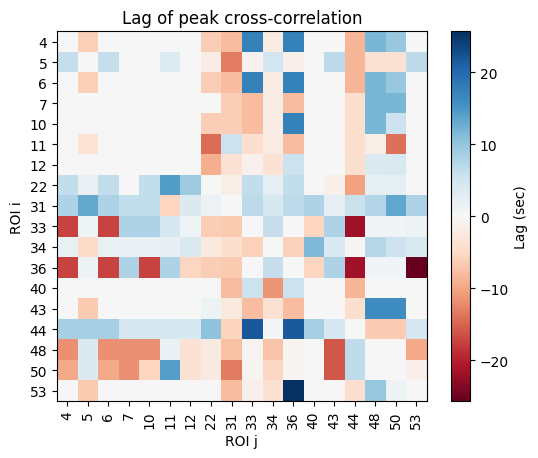

In [ ]:
n_timepoints = dff_zero_mean.shape[1]
n_rois = len(rois)
peak_corr = np.empty((n_rois, n_rois), dtype=float)
lag_samples = np.empty((n_rois, n_rois), dtype=int)

# Pre-compute the full range of lags once
lags = np.arange(-n_timepoints + 1, n_timepoints)  # length = 2*n_timepoints-1

for i in range(n_rois):
    x = dff_zero_mean[i]
    norm_x = np.linalg.norm(x)

    for j in range(n_rois):
        y = dff_zero_mean[j]
        norm_y = np.linalg.norm(y)

        # Full cross-correlation, normalised
        corr = correlate(x, y, mode="full") / (norm_x * norm_y)

        # Index of the global maximum
        idx_max = np.argmax(corr)

        # Store peak value and corresponding lag
        peak_corr[i, j] = corr[idx_max]
        lag_samples[i, j] = lags[idx_max]

# Optional: convert lags to seconds
fps = 20
dt = 1.0 / fps
lag_seconds = lag_samples * dt

plt.imshow(
    lag_seconds,
    cmap="RdBu",
    vmin=-np.max(np.abs(lag_seconds)),
    vmax=np.max(np.abs(lag_seconds)),
)
plt.colorbar(label="Lag (sec)")
plt.title("Lag of peak cross-correlation")
plt.xlabel("ROI j")
plt.ylabel("ROI i")
plt.xticks(range(n_rois_active), [f"{i}" for i in rois], rotation=90)
plt.yticks(range(n_rois_active), [f"{i}" for i in rois])
plt.show()

In [ ]:
trs = [traces_array[3], traces_array[9]]

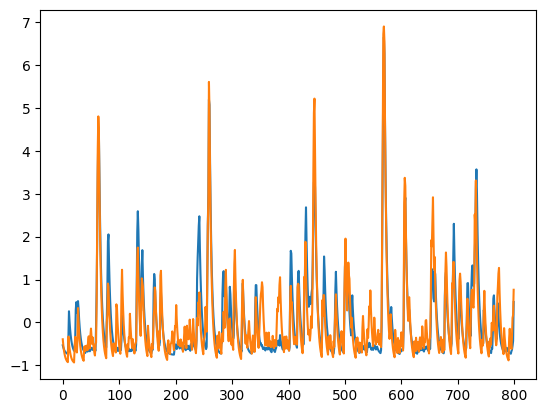

In [117]:
trs_array = np.array(trs)  # shape (n_rois, n_frames)

trs_dff_zero_mean = zscore(trs_array, axis=1)

for t in trs_dff_zero_mean:
    plt.plot(t)
plt.show()

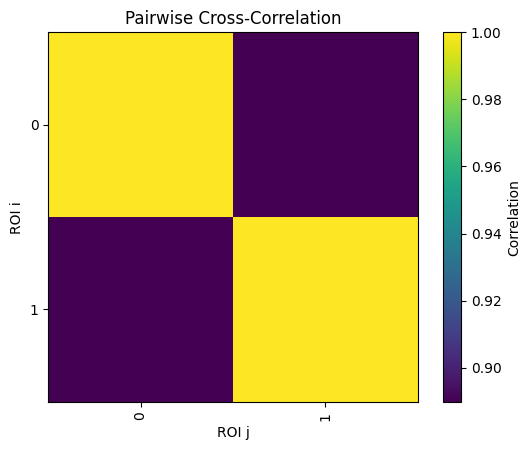

In [ ]:
n = len(trs)
cm = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        x = trs_dff_zero_mean[i]
        y = trs_dff_zero_mean[j]
        corr = correlate(x, y, mode="full")
        corr /= np.linalg.norm(x) * np.linalg.norm(y)  # normalises magnitude
        cm[i, j] = np.max(corr)
plt.imshow(cm, cmap="viridis")
plt.colorbar(label="Correlation")
plt.title("Pairwise Cross-Correlation")
plt.xlabel("ROI j")
plt.ylabel("ROI i")
plt.xticks(range(n), [f"{i}" for i in range(n)], rotation=90)
plt.yticks(range(n), [f"{i}" for i in range(n)])
plt.show()